In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from datetime import date
import matplotlib.pyplot as plt
import warnings
from hdfs import InsecureClient
warnings.filterwarnings("ignore")
import os
import seaborn as sns
from scipy.stats import ttest_ind
from imblearn.over_sampling import SMOTE
# import xgboost as xgb
import re
from sklearn.linear_model import LogisticRegression
# import statsmodels.api as sm
from scipy.stats import norm
import tensorflow as tf
from tensorflow import keras
import _pickle as cPickle
import joblib

In [1]:
scaler_filename = 'scalar_rtu_march.pkl'
weight_path = './weights_rtu_march'
woe_path = 'woe_rtu_march.pkl'
model_path = 'saved_model/rtu_march'

In [3]:
sale_data = pd.read_csv('sale_bau_dates.csv')
sale_data['sale_bau'] = np.where(sale_data['sale_bau'].isin(['BAU','Aggressive BAU','Normal BAU','Sub-normal BAU']),0,1)
sale_data = sale_data.rename(columns={'sale_bau':'sale_day'})
sale_data


,date,sale_day
0,01-Sep-21,0
1,02-Sep-21,0
2,03-Sep-21,1
3,04-Sep-21,1
4,05-Sep-21,1
...,...,...
329,27-Jul-22,0
330,28-Jul-22,0
331,29-Jul-22,0
332,30-Jul-22,0


In [4]:
url = "/user/dataplatform/indicium/temp/RohitMittal/PropensityModel_train_20220616/part-00000"
hdfs_endpoint = "http://10.65.31.100:50070"
client_hdfs = InsecureClient(hdfs_endpoint)
with client_hdfs.read(url, encoding = 'utf-8') as reader:
    iter_csv = pd.read_csv(reader)
data = iter_csv.copy()
data

,guid,deviceId,orderId,install_date,install_Channel,nxtMonthOrderDate,lastOrdDate,visitDate,last3DaysSearchEvents,last3DaysVisits,...,PDD2,paidAmount,cashBack,noOfItems,lastOrdAvgProdRating,lastOrdNPSScore,shipped_orders,delivered_orders,organicOrders,lastMonthOrderChannel
0,bd903054-1615-451d-8e50-63831d53b854,EB5400BD-662F-44BB-B74C-6570C50431EE,37567025072,NaN,NaN,NaN,20201011.0,2022-03-20 00:00:00.0,NaN,NaN,...,2020-10-21 00:00:00.0,3610.0,0.0,2.0,3.9000,NaN,1,1,1.0,NaN
1,03f774cb-ec8c-4d70-8a7d-b7d9cde53940,1e25fd6a89cf0db5,39418184993,NaN,NaN,NaN,20210328.0,2022-03-31 00:00:00.0,NaN,1.0,...,2021-04-03 00:00:00.0,908.0,37.0,2.0,3.4000,NaN,2,2,1.0,Google Channel
2,9f8d2533-ee92-4bd9-8634-3158dcd85ad3,d3fe9b17e61013ed,41274368311,NaN,NaN,NaN,20210820.0,2022-03-15 00:00:00.0,NaN,NaN,...,2021-08-29 00:00:00.0,588.0,20.0,2.0,4.0000,NaN,2,0,1.0,FB Channel
3,a8d638e7-06f8-4316-a82c-9b28b707ee42,ef8c5dca16563dff,41520160878,2021-09-04 00:00:00.0,FB Channel,NaN,20210904.0,2022-03-31 00:00:00.0,NaN,2.0,...,2021-09-09 00:00:00.0,876.0,164.0,2.0,3.8000,NaN,3,2,NaN,FB Channel
4,9ef7c01f-9972-442b-a662-83c443345523,NaN,41562262669,NaN,NaN,NaN,20210906.0,2022-03-21 00:00:00.0,NaN,NaN,...,2021-09-16 00:00:00.0,NaN,NaN,NaN,NaN,NaN,1,1,NaN,Google Channel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503957,f573ceef-ab87-4420-98bf-ccb5a095518a,b63aa77d8f7c6a1b,45276367947,2021-12-06 00:00:00.0,FB Channel,20220410.0,20220325.0,2022-03-28 00:00:00.0,NaN,NaN,...,2021-07-08 00:00:00.0,5074.0,1173.0,8.0,3.8875,NaN,8,3,1.0,FB Channel
5503958,49bab84d-0dec-4a04-97c7-5723f427f174,9a8a4597ea591b23,45293814316,2022-03-26 00:00:00.0,Non-Marketing,NaN,20220326.0,2022-03-27 00:00:00.0,NaN,NaN,...,2022-04-02 00:00:00.0,348.0,86.0,2.0,4.0000,NaN,2,2,1.0,Non-Marketing
5503959,ffff357e-961f-4363-9be5-ee7b55c1fb1d,c3b75c41ab1d9929,45317506846,2021-09-26 00:00:00.0,Non-Marketing,NaN,20220328.0,2022-03-31 00:00:00.0,NaN,1.0,...,2021-10-05 00:00:00.0,448.0,149.0,3.0,3.9000,NaN,3,2,1.0,Non-Marketing
5503960,401d3a56-16f8-4730-bd40-8dfb243eaeba,d666e1cb8425d2db,45335449675,2021-07-14 00:00:00.0,Non-Marketing,NaN,20220330.0,2022-03-30 00:00:00.0,NaN,2.0,...,2022-04-05 00:00:00.0,200.0,51.0,2.0,4.0000,10.0,2,2,1.0,Non-Marketing


In [5]:
data['deviceId'].nunique()

4445219

In [6]:
data[['nxtMonthOrderDate','lastOrdDate','visitDate','install_date','PDD2']]

,nxtMonthOrderDate,lastOrdDate,visitDate,install_date,PDD2
0,NaN,20201011.0,2022-03-20 00:00:00.0,NaN,2020-10-21 00:00:00.0
1,NaN,20210328.0,2022-03-31 00:00:00.0,NaN,2021-04-03 00:00:00.0
2,NaN,20210820.0,2022-03-15 00:00:00.0,NaN,2021-08-29 00:00:00.0
3,NaN,20210904.0,2022-03-31 00:00:00.0,2021-09-04 00:00:00.0,2021-09-09 00:00:00.0
4,NaN,20210906.0,2022-03-21 00:00:00.0,NaN,2021-09-16 00:00:00.0
...,...,...,...,...,...
5503957,20220410.0,20220325.0,2022-03-28 00:00:00.0,2021-12-06 00:00:00.0,2021-07-08 00:00:00.0
5503958,NaN,20220326.0,2022-03-27 00:00:00.0,2022-03-26 00:00:00.0,2022-04-02 00:00:00.0
5503959,NaN,20220328.0,2022-03-31 00:00:00.0,2021-09-26 00:00:00.0,2021-10-05 00:00:00.0
5503960,NaN,20220330.0,2022-03-30 00:00:00.0,2021-07-14 00:00:00.0,2022-04-05 00:00:00.0


In [7]:
data['nxtMonthOrderDate'] = pd.to_datetime(data['nxtMonthOrderDate'],format='%Y%m%d').dt.date
data['lastOrdDate'] = pd.to_datetime(data['lastOrdDate'],format='%Y%m%d').dt.date
data['visitDate'] = pd.to_datetime(data['visitDate'],format='%Y-%m-%d %H:%M:%S').dt.date
data['install_date'] = pd.to_datetime(data['install_date'],format='%Y-%m-%d %H:%M:%S').dt.date
data['PDD2'] = pd.to_datetime(data['PDD2'],format='%Y-%m-%d %H:%M:%S').dt.date

In [8]:
## removing WAP and web customers
data = data[data['deviceId'].notnull()]
## removing customers with install date beyond 2 years
data = data[data['install_date'].notnull()]
data

,guid,deviceId,orderId,install_date,install_Channel,nxtMonthOrderDate,lastOrdDate,visitDate,last3DaysSearchEvents,last3DaysVisits,...,PDD2,paidAmount,cashBack,noOfItems,lastOrdAvgProdRating,lastOrdNPSScore,shipped_orders,delivered_orders,organicOrders,lastMonthOrderChannel
3,a8d638e7-06f8-4316-a82c-9b28b707ee42,ef8c5dca16563dff,41520160878,2021-09-04,FB Channel,NaT,2021-09-04,2022-03-31,NaN,2.0,...,2021-09-09,876.0,164.0,2.0,3.800000,NaN,3,2,NaN,FB Channel
5,e7adf3df-efaa-4a90-b384-78c28a55e849,1663ecb08089e80c,42049229223,2021-11-19,FB Channel,NaT,2021-10-03,2022-03-24,NaN,NaN,...,2021-10-08,878.0,270.0,2.0,4.350000,NaN,2,2,1.0,FB Channel
6,e6193e06-8f2e-4358-8bbe-79ab082b96ec,831b460d3c6e6163,42110158060,2021-10-06,FB Channel,NaT,2021-10-06,2022-03-16,NaN,NaN,...,2021-10-14,539.0,196.0,1.0,4.200000,NaN,1,1,NaN,FB Channel
8,b19389d6-ff2d-40a4-9056-f2b25cc7bbdd,4c3b022052915f80,42617365502,2021-10-30,Non-Marketing,NaT,2021-10-30,2022-03-27,NaN,NaN,...,2021-08-12,1567.0,170.0,6.0,2.516667,NaN,6,5,1.0,Non-Marketing
10,9aebf4d1-3073-4ddf-9a77-2f4c5cd52dfc,89b9de2deb47b0b0,42899489096,2021-09-05,FB Channel,NaT,2021-11-15,2022-03-23,NaN,NaN,...,2021-11-25,1250.0,348.0,2.0,3.400000,NaN,2,2,1.0,Non-Marketing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503957,f573ceef-ab87-4420-98bf-ccb5a095518a,b63aa77d8f7c6a1b,45276367947,2021-12-06,FB Channel,2022-04-10,2022-03-25,2022-03-28,NaN,NaN,...,2021-07-08,5074.0,1173.0,8.0,3.887500,NaN,8,3,1.0,FB Channel
5503958,49bab84d-0dec-4a04-97c7-5723f427f174,9a8a4597ea591b23,45293814316,2022-03-26,Non-Marketing,NaT,2022-03-26,2022-03-27,NaN,NaN,...,2022-04-02,348.0,86.0,2.0,4.000000,NaN,2,2,1.0,Non-Marketing
5503959,ffff357e-961f-4363-9be5-ee7b55c1fb1d,c3b75c41ab1d9929,45317506846,2021-09-26,Non-Marketing,NaT,2022-03-28,2022-03-31,NaN,1.0,...,2021-10-05,448.0,149.0,3.0,3.900000,NaN,3,2,1.0,Non-Marketing
5503960,401d3a56-16f8-4730-bd40-8dfb243eaeba,d666e1cb8425d2db,45335449675,2021-07-14,Non-Marketing,NaT,2022-03-30,2022-03-30,NaN,2.0,...,2022-04-05,200.0,51.0,2.0,4.000000,10.0,2,2,1.0,Non-Marketing


In [9]:
data.head(5)

,guid,deviceId,orderId,install_date,install_Channel,nxtMonthOrderDate,lastOrdDate,visitDate,last3DaysSearchEvents,last3DaysVisits,...,PDD2,paidAmount,cashBack,noOfItems,lastOrdAvgProdRating,lastOrdNPSScore,shipped_orders,delivered_orders,organicOrders,lastMonthOrderChannel
3,a8d638e7-06f8-4316-a82c-9b28b707ee42,ef8c5dca16563dff,41520160878,2021-09-04,FB Channel,NaT,2021-09-04,2022-03-31,NaN,2.0,...,2021-09-09,876.0,164.0,2.0,3.800000,NaN,3,2,NaN,FB Channel
5,e7adf3df-efaa-4a90-b384-78c28a55e849,1663ecb08089e80c,42049229223,2021-11-19,FB Channel,NaT,2021-10-03,2022-03-24,NaN,NaN,...,2021-10-08,878.0,270.0,2.0,4.350000,NaN,2,2,1.0,FB Channel
6,e6193e06-8f2e-4358-8bbe-79ab082b96ec,831b460d3c6e6163,42110158060,2021-10-06,FB Channel,NaT,2021-10-06,2022-03-16,NaN,NaN,...,2021-10-14,539.0,196.0,1.0,4.200000,NaN,1,1,NaN,FB Channel
8,b19389d6-ff2d-40a4-9056-f2b25cc7bbdd,4c3b022052915f80,42617365502,2021-10-30,Non-Marketing,NaT,2021-10-30,2022-03-27,NaN,NaN,...,2021-08-12,1567.0,170.0,6.0,2.516667,NaN,6,5,1.0,Non-Marketing
10,9aebf4d1-3073-4ddf-9a77-2f4c5cd52dfc,89b9de2deb47b0b0,42899489096,2021-09-05,FB Channel,NaT,2021-11-15,2022-03-23,NaN,NaN,...,2021-11-25,1250.0,348.0,2.0,3.400000,NaN,2,2,1.0,Non-Marketing


In [10]:
data.isna().sum()

guid                           0
deviceId                       0
orderId                        0
install_date                   0
install_Channel                0
                          ...   
lastOrdNPSScore          3557206
shipped_orders                 0
delivered_orders               0
organicOrders             738732
lastMonthOrderChannel      30355
Length: 62, dtype: int64

In [11]:
data.columns

Index(['guid', 'deviceId', 'orderId', 'install_date', 'install_Channel',
       'nxtMonthOrderDate', 'lastOrdDate', 'visitDate',
       'last3DaysSearchEvents', 'last3DaysVisits', 'last3DaysDistinctPogs',
       'last3DaysTotPogsVisits', 'daysSinceLastOrgVisit',
       'daysSinceLastSearch', 'daysSinceLastATC', 'daysBetweenLast2Visits',
       'sdState', 'MensFashion_supercat_suborders', 'FMCG_supercat_suborders',
       'Books_supercat_suborders', 'GM_supercat_suborders',
       'Refurbished_supercat_suborders', 'KidsFashion_supercat_suborders',
       'TVShop_supercat_suborders', 'MobilesTablets_supercat_suborders',
       'Electronics_supercat_suborders', 'WomensFashion_supercat_suborders',
       'GeneralWellness_cat_suborders', 'MensClothing_cat_suborders',
       'Appliances_cat_suborders', 'FMCG_cat_suborders',
       'MobilePhones_cat_suborders', 'WomensEthnicWear_cat_suborders',
       'Watches_cat_suborders', 'WomensClothing_cat_suborders',
       'Books_cat_suborders', 'Home

In [12]:
train = data[(data['lastOrdDate']>=datetime(2022,3,1).date()) & (data['lastOrdDate']<=datetime(2022,3,31).date())]
train.head(5)

,guid,deviceId,orderId,install_date,install_Channel,nxtMonthOrderDate,lastOrdDate,visitDate,last3DaysSearchEvents,last3DaysVisits,...,PDD2,paidAmount,cashBack,noOfItems,lastOrdAvgProdRating,lastOrdNPSScore,shipped_orders,delivered_orders,organicOrders,lastMonthOrderChannel
42,11120d46-44fb-430b-9dc4-fb2fe67a6db2,e7e3290a90c43cde,44885709855,2022-03-01,FB Channel,NaT,2022-03-01,2022-03-21,NaN,NaN,...,2022-03-09,539.0,23.0,1.0,3.900000,NaN,1,0,NaN,FB Channel
43,121b117c-52f6-4eb9-a38a-11f58ac54d2f,1fa5c162d0a5b07f,44908268975,2021-12-05,Other Marketing Channels,2022-05-08,2022-03-02,2022-03-26,NaN,NaN,...,2021-11-28,2289.0,609.0,12.0,3.950000,NaN,13,7,1.0,Google Channel
44,1df72237-9f0a-43ae-adc2-0a874f098589,79c9985c28bc4535,44948688172,2021-08-06,Other Marketing Channels,2022-06-03,2022-03-04,2022-03-22,NaN,NaN,...,2022-03-12,6898.0,410.0,18.0,3.847222,8.0,13,12,1.0,Google Channel
45,d1c5ef05-dce8-428b-99a8-c956d455e50a,e946303065379404,44963408360,2021-05-15,FB Channel,2022-04-07,2022-03-05,2022-03-18,NaN,NaN,...,2022-02-17,4437.0,942.0,14.0,3.864286,NaN,15,11,NaN,Google Channel
47,82bceeed-da08-487a-b874-f020c33857ab,3153cd5cbcb31fb9,44976160651,2022-01-02,Non-Marketing,NaT,2022-03-05,2022-03-29,NaN,1.0,...,2022-02-02,7279.0,1951.0,16.0,3.425000,NaN,16,16,1.0,FB Channel


In [13]:
sale_data['date'] = pd.to_datetime(sale_data['date'],infer_datetime_format=True).dt.date
train = pd.merge(train, sale_data.rename(columns={'date':'lastOrdDate'}), on='lastOrdDate', how='left')
train = train.rename(columns={'sale_day':'last_order_on_sale_day'})
train = pd.merge(train, sale_data.rename(columns={'date':'install_date'}), on='install_date', how='left')
train = train.rename(columns={'sale_day':'install_on_sale_day'})
train['install_on_sale_day'] = train['install_on_sale_day'].fillna(0)
train['install_on_sale_day'] = train['install_on_sale_day'].astype(int)
train

,guid,deviceId,orderId,install_date,install_Channel,nxtMonthOrderDate,lastOrdDate,visitDate,last3DaysSearchEvents,last3DaysVisits,...,cashBack,noOfItems,lastOrdAvgProdRating,lastOrdNPSScore,shipped_orders,delivered_orders,organicOrders,lastMonthOrderChannel,last_order_on_sale_day,install_on_sale_day
0,11120d46-44fb-430b-9dc4-fb2fe67a6db2,e7e3290a90c43cde,44885709855,2022-03-01,FB Channel,NaT,2022-03-01,2022-03-21,NaN,NaN,...,23.0,1.0,3.900000,NaN,1,0,NaN,FB Channel,0,0
1,121b117c-52f6-4eb9-a38a-11f58ac54d2f,1fa5c162d0a5b07f,44908268975,2021-12-05,Other Marketing Channels,2022-05-08,2022-03-02,2022-03-26,NaN,NaN,...,609.0,12.0,3.950000,NaN,13,7,1.0,Google Channel,0,1
2,1df72237-9f0a-43ae-adc2-0a874f098589,79c9985c28bc4535,44948688172,2021-08-06,Other Marketing Channels,2022-06-03,2022-03-04,2022-03-22,NaN,NaN,...,410.0,18.0,3.847222,8.0,13,12,1.0,Google Channel,1,0
3,d1c5ef05-dce8-428b-99a8-c956d455e50a,e946303065379404,44963408360,2021-05-15,FB Channel,2022-04-07,2022-03-05,2022-03-18,NaN,NaN,...,942.0,14.0,3.864286,NaN,15,11,NaN,Google Channel,1,0
4,82bceeed-da08-487a-b874-f020c33857ab,3153cd5cbcb31fb9,44976160651,2022-01-02,Non-Marketing,NaT,2022-03-05,2022-03-29,NaN,1.0,...,1951.0,16.0,3.425000,NaN,16,16,1.0,FB Channel,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405663,f573ceef-ab87-4420-98bf-ccb5a095518a,b63aa77d8f7c6a1b,45276367947,2021-12-06,FB Channel,2022-04-10,2022-03-25,2022-03-28,NaN,NaN,...,1173.0,8.0,3.887500,NaN,8,3,1.0,FB Channel,0,1
1405664,49bab84d-0dec-4a04-97c7-5723f427f174,9a8a4597ea591b23,45293814316,2022-03-26,Non-Marketing,NaT,2022-03-26,2022-03-27,NaN,NaN,...,86.0,2.0,4.000000,NaN,2,2,1.0,Non-Marketing,0,0
1405665,ffff357e-961f-4363-9be5-ee7b55c1fb1d,c3b75c41ab1d9929,45317506846,2021-09-26,Non-Marketing,NaT,2022-03-28,2022-03-31,NaN,1.0,...,149.0,3.0,3.900000,NaN,3,2,1.0,Non-Marketing,0,0
1405666,401d3a56-16f8-4730-bd40-8dfb243eaeba,d666e1cb8425d2db,45335449675,2021-07-14,Non-Marketing,NaT,2022-03-30,2022-03-30,NaN,2.0,...,51.0,2.0,4.000000,10.0,2,2,1.0,Non-Marketing,0,0


In [14]:
train[['last_order_on_sale_day','install_on_sale_day']].isna().sum()

last_order_on_sale_day    0
install_on_sale_day       0
dtype: int64

In [15]:
print('customers with one or more orders in march 2022 : '+str(train.shape[0]))

customers with one or more orders in march 2022 : 1405668


In [16]:
train['target'] = np.where((train['nxtMonthOrderDate']>=datetime(2022,4,1).date()) & (train['nxtMonthOrderDate']<=datetime(2022,4,3).date()),1,0)


In [17]:
train['target'].value_counts()

0    1311597
1      94071
Name: target, dtype: int64

In [18]:
n1 = train[train['target']==1]
print('one or more orders in march and next order between 1 April and 3 April : '+str(n1.shape[0]))

one or more orders in march and next order between 1 April and 3 April : 94071


In [19]:
n2 = train[train['target']==0]
print('one or more orders in march and next order not between 1 April and 3 April : '+str(n2.shape[0]))

one or more orders in march and next order not between 1 April and 3 April : 1311597


In [20]:
## class balance
print('1 : '+str(round(n1.shape[0]*100/train.shape[0],2)))
print('0 : '+str(round(n2.shape[0]*100/train.shape[0],2)))

1 : 6.69
0 : 93.31


In [21]:
## class balance
# t1 = train[train['target']==0].sample(train[train['target']==1].shape[0])
# t2 = train[train['target']==1]
# train = pd.concat([t1,t2],ignore_index=True)
# train

In [22]:
## sanity check
train[(train['target']==1) & (pd.isnull(train['nxtMonthOrderDate']))]

,guid,deviceId,orderId,install_date,install_Channel,nxtMonthOrderDate,lastOrdDate,visitDate,last3DaysSearchEvents,last3DaysVisits,...,noOfItems,lastOrdAvgProdRating,lastOrdNPSScore,shipped_orders,delivered_orders,organicOrders,lastMonthOrderChannel,last_order_on_sale_day,install_on_sale_day,target


In [23]:
# train['target'].value_counts()

In [24]:
## generating features
train['days_since_install'] = (datetime(2022,3,31).date()-train['install_date']).dt.days
train['days_since_last_visit'] = (datetime(2022,3,31).date()-train['visitDate']).dt.days
train['days_since_last_order'] = (datetime(2022,3,31).date()-train['lastOrdDate']).dt.days
train

,guid,deviceId,orderId,install_date,install_Channel,nxtMonthOrderDate,lastOrdDate,visitDate,last3DaysSearchEvents,last3DaysVisits,...,shipped_orders,delivered_orders,organicOrders,lastMonthOrderChannel,last_order_on_sale_day,install_on_sale_day,target,days_since_install,days_since_last_visit,days_since_last_order
0,11120d46-44fb-430b-9dc4-fb2fe67a6db2,e7e3290a90c43cde,44885709855,2022-03-01,FB Channel,NaT,2022-03-01,2022-03-21,NaN,NaN,...,1,0,NaN,FB Channel,0,0,0,30,10,30
1,121b117c-52f6-4eb9-a38a-11f58ac54d2f,1fa5c162d0a5b07f,44908268975,2021-12-05,Other Marketing Channels,2022-05-08,2022-03-02,2022-03-26,NaN,NaN,...,13,7,1.0,Google Channel,0,1,0,116,5,29
2,1df72237-9f0a-43ae-adc2-0a874f098589,79c9985c28bc4535,44948688172,2021-08-06,Other Marketing Channels,2022-06-03,2022-03-04,2022-03-22,NaN,NaN,...,13,12,1.0,Google Channel,1,0,0,237,9,27
3,d1c5ef05-dce8-428b-99a8-c956d455e50a,e946303065379404,44963408360,2021-05-15,FB Channel,2022-04-07,2022-03-05,2022-03-18,NaN,NaN,...,15,11,NaN,Google Channel,1,0,0,320,13,26
4,82bceeed-da08-487a-b874-f020c33857ab,3153cd5cbcb31fb9,44976160651,2022-01-02,Non-Marketing,NaT,2022-03-05,2022-03-29,NaN,1.0,...,16,16,1.0,FB Channel,1,1,0,88,2,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405663,f573ceef-ab87-4420-98bf-ccb5a095518a,b63aa77d8f7c6a1b,45276367947,2021-12-06,FB Channel,2022-04-10,2022-03-25,2022-03-28,NaN,NaN,...,8,3,1.0,FB Channel,0,1,0,115,3,6
1405664,49bab84d-0dec-4a04-97c7-5723f427f174,9a8a4597ea591b23,45293814316,2022-03-26,Non-Marketing,NaT,2022-03-26,2022-03-27,NaN,NaN,...,2,2,1.0,Non-Marketing,0,0,0,5,4,5
1405665,ffff357e-961f-4363-9be5-ee7b55c1fb1d,c3b75c41ab1d9929,45317506846,2021-09-26,Non-Marketing,NaT,2022-03-28,2022-03-31,NaN,1.0,...,3,2,1.0,Non-Marketing,0,0,0,186,0,3
1405666,401d3a56-16f8-4730-bd40-8dfb243eaeba,d666e1cb8425d2db,45335449675,2021-07-14,Non-Marketing,NaT,2022-03-30,2022-03-30,NaN,2.0,...,2,2,1.0,Non-Marketing,0,0,0,260,1,1


In [25]:
# train['predicted_delivery_time_last_order'] = (train['PDD2']-train['lastOrdDate']).dt.days
# train[train['predicted_delivery_time_last_order']<0][['lastOrdDate','PDD2']]
# train = train.drop('predicted_delivery_time_last_order',axis=1)
## PDD2 before order date for many customers
## states should be only 28 unique values - state name not standardized

In [26]:
train.columns

Index(['guid', 'deviceId', 'orderId', 'install_date', 'install_Channel',
       'nxtMonthOrderDate', 'lastOrdDate', 'visitDate',
       'last3DaysSearchEvents', 'last3DaysVisits', 'last3DaysDistinctPogs',
       'last3DaysTotPogsVisits', 'daysSinceLastOrgVisit',
       'daysSinceLastSearch', 'daysSinceLastATC', 'daysBetweenLast2Visits',
       'sdState', 'MensFashion_supercat_suborders', 'FMCG_supercat_suborders',
       'Books_supercat_suborders', 'GM_supercat_suborders',
       'Refurbished_supercat_suborders', 'KidsFashion_supercat_suborders',
       'TVShop_supercat_suborders', 'MobilesTablets_supercat_suborders',
       'Electronics_supercat_suborders', 'WomensFashion_supercat_suborders',
       'GeneralWellness_cat_suborders', 'MensClothing_cat_suborders',
       'Appliances_cat_suborders', 'FMCG_cat_suborders',
       'MobilePhones_cat_suborders', 'WomensEthnicWear_cat_suborders',
       'Watches_cat_suborders', 'WomensClothing_cat_suborders',
       'Books_cat_suborders', 'Home

In [27]:
## sanity check
train[train['days_since_last_order']>30]

,guid,deviceId,orderId,install_date,install_Channel,nxtMonthOrderDate,lastOrdDate,visitDate,last3DaysSearchEvents,last3DaysVisits,...,shipped_orders,delivered_orders,organicOrders,lastMonthOrderChannel,last_order_on_sale_day,install_on_sale_day,target,days_since_install,days_since_last_visit,days_since_last_order


In [28]:
categorical_cols = ['lastMonthOrderChannel','install_Channel','install_on_sale_day','last_order_on_sale_day']
numerical_cols = ['last3DaysSearchEvents', 'last3DaysVisits', 'last3DaysDistinctPogs','last3DaysTotPogsVisits', 'daysSinceLastOrgVisit',
                  'daysSinceLastSearch', 'daysSinceLastATC', 'daysBetweenLast2Visits','paidAmount', 'cashBack', 'noOfItems', 'lastOrdAvgProdRating',
                  'lastOrdNPSScore', 'shipped_orders', 'delivered_orders','organicOrders','days_since_install','days_since_last_visit','days_since_last_order',
                  'MensFashion_supercat_suborders', 'FMCG_supercat_suborders',
                  'Books_supercat_suborders', 'GM_supercat_suborders','Refurbished_supercat_suborders', 'KidsFashion_supercat_suborders',
                  'TVShop_supercat_suborders', 'MobilesTablets_supercat_suborders','Electronics_supercat_suborders', 'WomensFashion_supercat_suborders',
                  'GeneralWellness_cat_suborders', 'MensClothing_cat_suborders','Appliances_cat_suborders', 'FMCG_cat_suborders',
                  'MobilePhones_cat_suborders', 'WomensEthnicWear_cat_suborders','Watches_cat_suborders', 'WomensClothing_cat_suborders',
                  'Books_cat_suborders', 'HomeKitchen_cat_suborders','FashionJewellery_cat_suborders', 'TVAudioVideo_cat_suborders',
                  'Refurbished_cat_suborders', 'KidsApparel_cat_suborders','FashionAccessories_cat_suborders', 'SexualWellness_cat_suborders',
                  'AutoTools_cat_suborders', 'GM_cat_suborders', 'TVShop_cat_suborders','Beauty_cat_suborders', 'Footwear_cat_suborders',
                  'ElectronicsAccessories_cat_suborders', 'SportsFitness_cat_suborders','MobileAccessories_cat_suborders', 'PersonalCare_cat_suborders']


In [29]:
## EDA ##

In [30]:
# df = train.copy()
# df = df[df['target']==0]
# t = pd.DataFrame(df['lastOrdCategory'].value_counts()).reset_index()
# t.columns = ['label','freq']
# t['freq'] = t['freq']*100/t['freq'].sum()
# t

In [31]:
# for column_name in categorical_cols:
#     col = column_name
#     fig,(ax1,ax2) = plt.subplots(1,2)
#     df = train.copy()
#     df = df[df['target']==1]
#     t = pd.DataFrame(df[col].value_counts()).reset_index()
#     t.columns = ['label','freq']
#     t['freq'] = t['freq']*100/t['freq'].sum()
#     ax1.pie(t['freq'], labels = t['label'], wedgeprops=dict(width=.3))
#     labels = [f'{l}, {s:0.1f}%' for l, s in zip(t['label'], t['freq'])]
#     ax1.legend(t['label'],labels=labels,loc='best',bbox_to_anchor=(1,1))
#     ax1.set_title('Distirbution of '+str(col)+' for ordered')
#     df = train.copy()
#     df = df[df['target']==0]
#     t = pd.DataFrame(df[col].value_counts()).reset_index()
#     t.columns = ['label','freq']
#     t['freq'] = t['freq']*100/t['freq'].sum()
#     ax2.pie(t['freq'], labels = t['label'], wedgeprops=dict(width=.3))
#     labels = [f'{l}, {s:0.1f}%' for l, s in zip(t['label'], t['freq'])]
#     ax2.legend(t['label'],labels=labels,loc='best',bbox_to_anchor=(1,1))
#     ax2.set_title('Distirbution of '+str(col)+' for no orders')
#     fig.suptitle('Orders',x=1.2,y=1)
#     plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=2, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=0.4)
#     plt.show()

In [32]:
# for column_name in numerical_cols:
#     col = column_name
#     d = {'Ordered_0':'','Ordered_1':''}
#     t = train.copy()
#     t = t[t['target']==1]
#     d['Ordered_1'] = t[col].mean()
#     t = train.copy()
#     t = t[t['target']==0]
#     d['Ordered_0'] = t[col].mean()
#     keys = list(d.keys())
#     values = list(d.values())
#     plt.bar(keys,values)
#     for i, v in enumerate(values):
#         plt.text(i,v,str(v))
#     plt.xlabel("Ordered/Not ordered")
#     plt.ylabel(str(col))
#     plt.title("Average "+str(col))
#     plt.show()
#     plt.clf()

In [33]:
## t test
# train['last3DaysVisits'] = train['last3DaysVisits'].astype(int)
# t, p = ttest_ind(train[train['target']==1]['last3DaysVisits'], train[train['target']==0]['last3DaysVisits'], equal_var=False)
# print('t stat : '+str(t)+' p value : '+str(p))


In [34]:
pd.DataFrame(train.isna().sum()).to_csv('null_values.csv')

In [35]:
train['lastMonthOrderChannel'] = train['lastMonthOrderChannel'].fillna('Other Marketing Channels')

In [36]:
train.shape[0]

1405668

In [37]:
fill_large = ['daysSinceLastOrgVisit','daysSinceLastSearch','daysSinceLastATC','daysBetweenLast2Visits']
fill_small = ['last3DaysSearchEvents','last3DaysVisits','last3DaysDistinctPogs','last3DaysTotPogsVisits','cashBack',
             'lastOrdAvgProdRating','lastOrdNPSScore','organicOrders']
null_columns = fill_large+fill_small
null_columns.append('lastMonthOrderChannel')
null_columns

['daysSinceLastOrgVisit',
 'daysSinceLastSearch',
 'daysSinceLastATC',
 'daysBetweenLast2Visits',
 'last3DaysSearchEvents',
 'last3DaysVisits',
 'last3DaysDistinctPogs',
 'last3DaysTotPogsVisits',
 'cashBack',
 'lastOrdAvgProdRating',
 'lastOrdNPSScore',
 'organicOrders',
 'lastMonthOrderChannel']

In [38]:
## generating columns to mark null values
for col in null_columns:
    train[str(col)+'_null'] = np.where(train[col].isna(),1,0)

In [39]:
train.columns

Index(['guid', 'deviceId', 'orderId', 'install_date', 'install_Channel',
       'nxtMonthOrderDate', 'lastOrdDate', 'visitDate',
       'last3DaysSearchEvents', 'last3DaysVisits', 'last3DaysDistinctPogs',
       'last3DaysTotPogsVisits', 'daysSinceLastOrgVisit',
       'daysSinceLastSearch', 'daysSinceLastATC', 'daysBetweenLast2Visits',
       'sdState', 'MensFashion_supercat_suborders', 'FMCG_supercat_suborders',
       'Books_supercat_suborders', 'GM_supercat_suborders',
       'Refurbished_supercat_suborders', 'KidsFashion_supercat_suborders',
       'TVShop_supercat_suborders', 'MobilesTablets_supercat_suborders',
       'Electronics_supercat_suborders', 'WomensFashion_supercat_suborders',
       'GeneralWellness_cat_suborders', 'MensClothing_cat_suborders',
       'Appliances_cat_suborders', 'FMCG_cat_suborders',
       'MobilePhones_cat_suborders', 'WomensEthnicWear_cat_suborders',
       'Watches_cat_suborders', 'WomensClothing_cat_suborders',
       'Books_cat_suborders', 'Home

In [40]:
train[fill_large] = train[fill_large].fillna(10000)
train[fill_small] = train[fill_small].fillna(0)

In [41]:
order_dist = pd.DataFrame(columns=['days_to_next_order'])
order_dist['days_to_next_order'] = (train['nxtMonthOrderDate']-train['lastOrdDate']).dt.days
order_dist = order_dist.dropna()
order_dist = order_dist.sort_values(by='days_to_next_order',ascending=True).reset_index(drop=True)
order_dist['bucket'] = pd.qcut(order_dist['days_to_next_order'],10)
order_dist = order_dist.groupby('bucket').agg({'days_to_next_order':'count'})
order_dist = order_dist.rename(columns={'days_to_next_order':'order_count'})
order_dist['salience%'] = order_dist['order_count']*100/order_dist['order_count'].sum()
order_dist['cum_salience'] = order_dist['salience%'].cumsum()
order_dist = order_dist.drop(['order_count'],axis=1)
order_dist = order_dist.reset_index()
order_dist

,bucket,salience%,cum_salience
0,"(0.999, 7.0]",10.402209,10.402209
1,"(7.0, 12.0]",10.076855,20.479064
2,"(12.0, 18.0]",11.166466,31.645529
3,"(18.0, 23.0]",9.063874,40.709403
4,"(23.0, 29.0]",10.793007,51.502411
5,"(29.0, 35.0]",9.625460,61.127871
6,"(35.0, 43.0]",9.739940,70.867811
7,"(43.0, 54.0]",9.787485,80.655296
8,"(54.0, 69.0]",9.535778,90.191074
9,"(69.0, 106.0]",9.808926,100.000000


In [42]:
train[['last3DaysSearchEvents', 'last3DaysVisits', 'last3DaysDistinctPogs','last3DaysTotPogsVisits', 'daysSinceLastOrgVisit',
      'daysSinceLastSearch', 'daysSinceLastATC', 'daysBetweenLast2Visits','paidAmount', 'cashBack', 'noOfItems', 'lastOrdAvgProdRating',
      'lastOrdNPSScore', 'shipped_orders', 'delivered_orders','organicOrders','days_since_install','days_since_last_visit','days_since_last_order'
      ]].corr()


,last3DaysSearchEvents,last3DaysVisits,last3DaysDistinctPogs,last3DaysTotPogsVisits,daysSinceLastOrgVisit,daysSinceLastSearch,daysSinceLastATC,daysBetweenLast2Visits,paidAmount,cashBack,noOfItems,lastOrdAvgProdRating,lastOrdNPSScore,shipped_orders,delivered_orders,organicOrders,days_since_install,days_since_last_visit,days_since_last_order
last3DaysSearchEvents,1.000000,0.406676,0.586975,0.569522,-0.018511,-0.087352,-0.039649,0.001641,0.059425,0.070281,0.061294,-0.025396,0.021612,0.055844,0.046553,0.066242,-0.040758,-0.201676,-0.210263
last3DaysVisits,0.406676,1.000000,0.555551,0.553698,-0.033005,-0.065023,-0.084276,-0.030276,0.115360,0.146846,0.127126,-0.018832,0.068682,0.124600,0.123317,0.069020,-0.048908,-0.497040,-0.404220
last3DaysDistinctPogs,0.586975,0.555551,1.000000,0.954269,-0.016315,-0.059888,-0.084596,-0.004883,0.125156,0.164480,0.139553,-0.019428,0.047613,0.136717,0.131637,0.060410,-0.017718,-0.279597,-0.287143
last3DaysTotPogsVisits,0.569522,0.553698,0.954269,1.000000,-0.013886,-0.052413,-0.081871,-0.002624,0.117743,0.154485,0.128669,-0.019217,0.044874,0.125594,0.120099,0.055216,-0.022340,-0.257817,-0.285142
daysSinceLastOrgVisit,-0.018511,-0.033005,-0.016315,-0.013886,1.000000,0.168283,0.056556,0.107927,-0.028822,-0.032250,-0.033809,0.013131,-0.017808,-0.035535,-0.033768,-0.180609,-0.027419,0.022311,-0.024515
daysSinceLastSearch,-0.087352,-0.065023,-0.059888,-0.052413,0.168283,1.000000,0.160294,0.090539,-0.088401,-0.096816,-0.104285,0.049847,-0.053424,-0.110271,-0.105008,-0.207264,-0.113183,0.061680,-0.057899
daysSinceLastATC,-0.039649,-0.084276,-0.084596,-0.081871,0.056556,0.160294,1.000000,0.043075,-0.154172,-0.180974,-0.187941,0.029831,-0.099413,-0.188691,-0.190428,-0.111129,-0.167331,0.077499,-0.016850
daysBetweenLast2Visits,0.001641,-0.030276,-0.004883,-0.002624,0.107927,0.090539,0.043075,1.000000,-0.019973,-0.024145,-0.024695,0.005124,-0.012764,-0.028303,-0.028239,0.002358,-0.054244,0.013114,-0.060172
paidAmount,0.059425,0.115360,0.125156,0.117743,-0.028822,-0.088401,-0.154172,-0.019973,1.000000,0.830686,0.859002,-0.050831,0.123802,0.825979,0.768525,0.130938,0.160801,-0.083049,-0.089891
cashBack,0.070281,0.146846,0.164480,0.154485,-0.032250,-0.096816,-0.180974,-0.024145,0.830686,1.000000,0.861432,-0.036704,0.141972,0.851671,0.808830,0.142792,0.182367,-0.106111,-0.099588


In [43]:
def iv_variable(data, indep, dep):
    sub_data = data[[indep, dep]].copy()
    event = sub_data[dep].sum()
    non_event = sub_data.shape[0] - event
    iv_data = sub_data.groupby(indep).agg(['sum', 'size']).rename(columns = {'sum': 'event', 'size': 'total'})
    iv_data.columns = iv_data.columns.droplevel(level=0)
    iv_data = iv_data.reset_index(drop = False)
    iv_data['non_event'] = iv_data['total'] - iv_data['event'] 
    iv_data['per_event'] = iv_data['event']/event
    iv_data['per_non_event'] = iv_data['non_event']/non_event
    iv_data['woe'] = iv_data['woe'] = np.log(((iv_data['non_event'] + 0.5)/non_event)/((iv_data['event'] + 0.5)/event)) * (iv_data['per_non_event'] - iv_data['per_event'])
    iv_data['woe'] = 100*iv_data['woe']
    iv_data['cat_conversion'] = iv_data['event']/iv_data['total']
    base_conv = event/(event+non_event)
    iv_data['woe'] = np.where(iv_data['cat_conversion'] < base_conv, iv_data['woe']*(-1.0), iv_data['woe'])
    iv_data = iv_data[[indep, 'woe']]
    return(iv_data)


In [44]:
numerical_cols = ['last3DaysSearchEvents', 'last3DaysVisits', 'last3DaysDistinctPogs','last3DaysTotPogsVisits', 'daysSinceLastOrgVisit',
                  'daysSinceLastSearch', 'daysSinceLastATC', 'daysBetweenLast2Visits','paidAmount', 'cashBack', 'noOfItems', 'lastOrdAvgProdRating',
                  'lastOrdNPSScore', 'shipped_orders', 'delivered_orders','organicOrders','days_since_install','days_since_last_visit','days_since_last_order',
                  'MensFashion_supercat_suborders', 'FMCG_supercat_suborders',
                  'Books_supercat_suborders', 'GM_supercat_suborders','Refurbished_supercat_suborders', 'KidsFashion_supercat_suborders',
                  'TVShop_supercat_suborders', 'MobilesTablets_supercat_suborders','Electronics_supercat_suborders', 'WomensFashion_supercat_suborders',
                  'GeneralWellness_cat_suborders', 'MensClothing_cat_suborders','Appliances_cat_suborders', 'FMCG_cat_suborders',
                  'MobilePhones_cat_suborders', 'WomensEthnicWear_cat_suborders','Watches_cat_suborders', 'WomensClothing_cat_suborders',
                  'Books_cat_suborders', 'HomeKitchen_cat_suborders','FashionJewellery_cat_suborders', 'TVAudioVideo_cat_suborders',
                  'Refurbished_cat_suborders', 'KidsApparel_cat_suborders','FashionAccessories_cat_suborders', 'SexualWellness_cat_suborders',
                  'AutoTools_cat_suborders', 'GM_cat_suborders', 'TVShop_cat_suborders','Beauty_cat_suborders', 'Footwear_cat_suborders',
                  'ElectronicsAccessories_cat_suborders', 'SportsFitness_cat_suborders','MobileAccessories_cat_suborders', 'PersonalCare_cat_suborders',
                  'daysSinceLastOrgVisit_null', 'daysSinceLastSearch_null','daysSinceLastATC_null','daysBetweenLast2Visits_null',
                  'last3DaysSearchEvents_null', 'last3DaysVisits_null','last3DaysDistinctPogs_null', 'last3DaysTotPogsVisits_null',
                  'cashBack_null', 'lastOrdAvgProdRating_null', 'lastOrdNPSScore_null','organicOrders_null']
features = numerical_cols+categorical_cols
features.append('lastOrdDate')
features.append('deviceId')
X = train[features]


In [45]:
len(features)

72

In [46]:
# X = pd.get_dummies(X,columns=categorical_cols,drop_first=True)
y = train['target']

In [47]:
woe_dict = {}

for var in ['lastMonthOrderChannel','install_Channel']:
    iv_var = iv_variable(train, var, 'target')
    woe_dict[var] = dict(zip(iv_var[var], iv_var['woe']))
    X = pd.merge(X, iv_var, how = 'left', on = var).drop(columns = [var]).rename(columns = {'woe': var})

In [48]:
f = open(woe_path,'wb')
cPickle.dump(woe_dict,f,-1)
f.close()

In [49]:
from sklearn.preprocessing import StandardScaler

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X = X.drop('lastOrdDate',axis=1)
X = X.set_index('deviceId')
# oversample = SMOTE()
# X, y = oversample.fit_resample(X, y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [53]:
## scaling numerical features
scalar = StandardScaler()
X_train[numerical_cols] = scalar.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scalar.transform(X_val[numerical_cols])
X_test[numerical_cols] = scalar.transform(X_test[numerical_cols])

joblib.dump(scalar, scaler_filename) 

['scalar1.pkl']

In [54]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

In [55]:
# nan_check = pd.DataFrame(X_train.isna().sum().reset_index())
# nan_check = nan_check.rename(columns={'index':'variable',0:'nan'})
# nan_check[nan_check['nan']==1]

In [56]:
print('total : '+str(y_train.shape[0]))
print('class 1 : '+str(y_train.sum()))
print('class 0 : '+str(y_train.shape[0]-y_train.sum()))

total : 1124534
class 1 : 75327
class 0 : 1049207


In [57]:
y_train.sum()*100/y_train.shape[0]

6.698508004204408

In [58]:
# from sklearn.svm import LinearSVC

In [59]:
# xgb_clf = LinearSVC()
# xgb_clf.fit(X_train, y_train)

In [60]:
# ## xg boost
# xgb_clf = xgb.XGBClassifier(max_depth = 6,
#                            min_child_weight = 1,
#                            learning_rate = 0.1,
#                            n_estimators = 200,
#                            objective = 'binary:logistic',
#                            gamma = 5,
#                            n_jobs = 30,
#                            use_label_encoder=False
#                            )


# xgb_clf.fit(X_train, y_train, eval_metric = 'error', 
#             eval_set = [(X_train, y_train), (X_val, y_val)], early_stopping_rounds = 200)

In [61]:
# # getting variable importance
# var_imp = xgb_clf.get_booster().get_score(importance_type = 'total_gain')
# imp_data = pd.DataFrame({'feature': list(var_imp.keys()), 'importance': list(var_imp.values())})
# imp_data = imp_data.sort_values(by = 'importance', ascending = False)
# imp_data.importance = round(imp_data.importance*100/np.sum(imp_data.importance),2)
# imp_data.reset_index(drop = True, inplace = True)
# imp_data

In [62]:
metrics = [keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.Accuracy(name='accuracy')]

2022-08-10 18:01:35.766825: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-10 18:01:35.766962: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (datascience-adhocprocesses-4002): /proc/driver/nvidia/version does not exist
2022-08-10 18:01:35.770460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [63]:
def make_model(metrics=metrics, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
    keras.layers.Dense(16, activation='relu',input_shape=(X_train.shape[-1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation='relu',input_shape=(16,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid',
                     bias_initializer=output_bias),
    ])
    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
    return model

In [64]:
y_train.sum()*100/len(y_train)

6.698508004204408

In [65]:
initial_bias = np.log([y_train.sum()/len(y_train)])
initial_bias

array([-2.70328537])

In [66]:
model = make_model(output_bias=initial_bias)
model.predict(X_train[:10])

1/1 [==============================] - 0s 184ms/step


array([[0.04172494],
       [0.05003903],
       [0.07922262],
       [0.02966389],
       [0.04126919],
       [0.0318986 ],
       [0.05367076],
       [0.09845611],
       [0.03892855],
       [0.03712739]], dtype=float32)

In [67]:
model.save_weights(weight_path)

In [68]:
BATCH_SIZE = 500
EPOCHS = 200

In [69]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_precision', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [70]:
weight_for_0 = (1 / (len(y_train)-y_train.sum()) * (len(y_train) / 2.0))
weight_for_1 = (1 / y_train.sum()) * (len(y_train) / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [71]:
class_weight

{0: 0.5358971108656347, 1: 7.464348772684429}

In [72]:
model = make_model()
model.load_weights(weight_path)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
    class_weight=class_weight)

Epoch 1/200
2250/2250 [==============================] - 12s 5ms/step - loss: 0.6424 - precision: 0.1444 - recall: 0.5736 - accuracy: 1.1560e-04 - val_loss: 0.5407 - val_precision: 0.1548 - val_recall: 0.7196 - val_accuracy: 2.1342e-05
Epoch 2/200
2250/2250 [==============================] - 10s 4ms/step - loss: 0.5658 - precision: 0.1432 - recall: 0.6996 - accuracy: 4.1795e-05 - val_loss: 0.5450 - val_precision: 0.1504 - val_recall: 0.7546 - val_accuracy: 4.2684e-05
Epoch 3/200
2250/2250 [==============================] - 10s 4ms/step - loss: 0.5509 - precision: 0.1457 - recall: 0.7338 - accuracy: 3.3792e-05 - val_loss: 0.5309 - val_precision: 0.1529 - val_recall: 0.7619 - val_accuracy: 2.8456e-05
Epoch 4/200
2250/2250 [==============================] - 10s 4ms/step - loss: 0.5418 - precision: 0.1456 - recall: 0.7586 - accuracy: 3.1124e-05 - val_loss: 0.5461 - val_precision: 0.1497 - val_recall: 0.7792 - val_accuracy: 2.8456e-05
Epoch 5/200
2250/2250 [==============================] -

In [73]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                1136      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________


In [74]:
## save model for inference
model.save(model_path)

INFO:tensorflow:Assets written to: saved_model/my_model1/assets


In [75]:
## load model for inference
new_model = tf.keras.models.load_model(model_path)
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                1136      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________


In [76]:
## logistic regression
# model=sm.Logit(y_train,X_train)
# model=model.fit()
# print(model.summary2())

In [77]:
# def logit_p1value(model, x):
#     p1 = model.predict_proba(x)
#     n1 = len(p1)
#     m1 = len(model.coef_[0]) + 1
#     coefs = np.concatenate([model.intercept_, model.coef_[0]])
#     x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
#     answ = np.zeros((m1, m1))
#     for i in range(n1):
#         answ = answ + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p1[i,1] * p1[i, 0]
#     vcov = np.linalg.inv(np.matrix(answ))
#     se = np.sqrt(np.diag(vcov))
#     t1 =  coefs/se  
#     p1 = (1 - norm.cdf(abs(t1))) * 2
#     return p1

In [78]:
# weight_0 = X_train.shape[0]/(X_train.shape[0]-y_train.sum())
# print(weight_0)
# weight_1 = X_train.shape[0]/y_train.sum()
# print(weight_1)
# model = LogisticRegression(class_weight={0:weight_0,1:weight_1})
# model = model.fit(X_train, y_train)

In [79]:
# coeff = pd.DataFrame(columns=['feature','coeff'])
# coeff['feature'] = X_train.columns.tolist()
# coeff['coeff'] = list(model.coef_[0])
# coeff = coeff.sort_values(by='coeff',ascending=False).reset_index(drop=True)
# coeff['pvalue'] = list(logit_p1value(model, X_train))[1:]
# coeff['pvalue'] = round(coeff['pvalue'],4)
# coeff

In [80]:
# coeff[coeff['pvalue']<0.05]

In [81]:
## logistic prediction
# predicted_class = model.predict(X_test)
# predictions = pd.DataFrame(columns=['actual','predicted'])
# predictions['actual'] = list(y_test)
# predictions['predicted'] = list(predicted_class)
# predictions['predicted_class'] = np.where(predictions['predicted']>0.5,1,0)
# predictions

In [82]:
## XGB prediction
# predicted_class = xgb_clf.predict_proba(X_test)[:,1]
# predictions = pd.DataFrame(columns=['actual','predicted'])
# predictions['actual'] = list(y_test)
# predictions['predicted'] = list(predicted_class)
# predictions['predicted_class'] = np.where(predictions['predicted']>0.5,1,0)

In [83]:
predicted_class = model.predict(X_test, batch_size=BATCH_SIZE).flatten()
predictions = pd.DataFrame(columns=['actual','predicted'])
predictions['actual'] = list(y_test)
predictions['predicted'] = list(predicted_class)
predictions['predicted_class'] = np.where(predictions['predicted']>0.5,1,0)

282/282 [==============================] - 1s 2ms/step


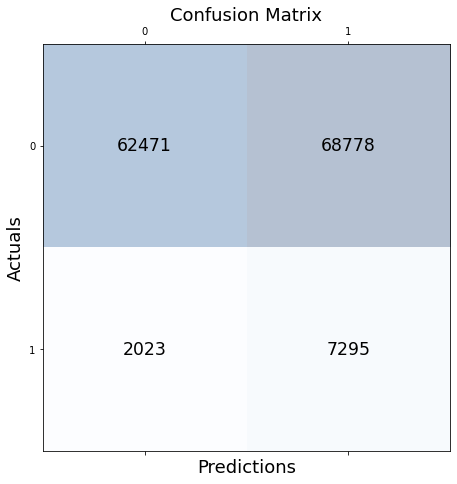

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=predictions['actual'], y_pred=predictions['predicted_class'])
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [85]:
from sklearn.metrics import classification_report

In [86]:
print(classification_report(predictions['actual'],predictions['predicted_class']))

              precision    recall  f1-score   support

           0       0.97      0.48      0.64    131249
           1       0.10      0.78      0.17      9318

    accuracy                           0.50    140567
   macro avg       0.53      0.63      0.40    140567
weighted avg       0.91      0.50      0.61    140567



In [87]:
## test data decile distribution
out_of_time = predictions[['actual','predicted']]
out_of_time = out_of_time.reset_index()
out_of_time['decile'] = pd.cut(out_of_time['predicted'], bins = np.arange(0,1.01, 0.1))
out = out_of_time.groupby(['decile'])['actual'].agg(['size', 'sum']).reset_index(drop = False).rename(columns = {'size': 'count', 'sum': 'orders'})
out['order_per'] = out['orders']*100/out['count']
out['salience'] = out['count']*100/out_of_time.shape[0]
out


,decile,count,orders,order_per,salience
0,"(0.0, 0.1]",9276,41,0.442001,6.598988
1,"(0.1, 0.2]",14298,283,1.979298,10.171662
2,"(0.2, 0.3]",12686,394,3.105786,9.024878
3,"(0.3, 0.4]",14207,559,3.934680,10.106924
4,"(0.4, 0.5]",14027,746,5.318315,9.978871
5,"(0.5, 0.6]",11957,771,6.448106,8.506264
6,"(0.6, 0.7]",11039,858,7.772443,7.853195
7,"(0.7, 0.8]",11366,862,7.584023,8.085824
8,"(0.8, 0.9]",12897,1027,7.963092,9.174984
9,"(0.9, 1.0]",28814,3777,13.108211,20.498410


In [88]:
## testing on april data

In [89]:
url = "/user/dataplatform/indicium/temp/RohitMittal/PropensityModel_test_20220616/part-00000"
hdfs_endpoint = "http://10.65.31.100:50070"
client_hdfs = InsecureClient(hdfs_endpoint)
with client_hdfs.read(url, encoding = 'utf-8') as reader:
    iter_csv = pd.read_csv(reader)
test = iter_csv.copy()
test

,guid,deviceId,orderId,install_date,install_Channel,nxtMonthOrderDate,lastOrdDate,visitDate,last3DaysSearchEvents,last3DaysVisits,...,PDD2,paidAmount,cashBack,noOfItems,lastOrdAvgProdRating,lastOrdNPSScore,shipped_orders,delivered_orders,organicOrders,lastMonthOrderChannel
0,b8cf247d-d12a-4c74-8635-10b69f14367e,fd86194a30bc45bd,37108310075,NaN,NaN,20220601.0,20200903.0,2022-04-24 00:00:00.0,NaN,NaN,...,2020-09-09 00:00:00.0,1019.0,30.0,3.0,2.950000,NaN,2,2,1.0,NaN
1,88ec204f-23e0-4a86-a6e3-c9081c7a1f44,75ba5ab55d4d4905,37238393030,NaN,NaN,NaN,20200912.0,2022-04-15 00:00:00.0,NaN,NaN,...,2020-10-03 00:00:00.0,722.0,0.0,2.0,3.900000,NaN,2,2,1.0,NaN
2,85891626-0276-4e13-b470-89a8e8d4f267,be902d43f04265d2,38091214167,NaN,NaN,NaN,20201121.0,2022-04-30 00:00:00.0,NaN,1.0,...,2020-11-28 00:00:00.0,489.0,0.0,1.0,3.300000,NaN,1,1,NaN,NaN
3,c4c9948d-252d-4648-a206-4175777ac81a,dcf37707b3fb3903,41067153188,2021-07-30 00:00:00.0,FB Channel,NaN,20210805.0,2022-04-21 00:00:00.0,NaN,NaN,...,2020-08-01 00:00:00.0,730.0,97.0,2.0,3.850000,NaN,4,2,1.0,Non-Marketing
4,de471b12-01ee-4bd5-a1d2-bb573386862a,4bf2085b23d4e7e2,41499954672,NaN,NaN,NaN,20210903.0,2022-04-25 00:00:00.0,NaN,NaN,...,2021-09-10 00:00:00.0,625.0,224.0,1.0,3.300000,10.0,1,1,1.0,Google Channel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5257022,ddd27477-7e6c-4686-a974-f8873cc5399d,237155dbdda219dc,45612995031,2021-09-01 00:00:00.0,FB Channel,NaN,20220417.0,2022-04-30 00:00:00.0,NaN,1.0,...,2022-02-20 00:00:00.0,646.0,57.0,3.0,3.766667,NaN,3,3,NaN,FB Channel
5257023,822c9db0-07b7-4319-8fcd-a881b87be7da,8a038feece8355d4,45628619505,2022-04-19 00:00:00.0,FB Channel,NaN,20220419.0,2022-04-25 00:00:00.0,NaN,NaN,...,2022-04-26 00:00:00.0,899.0,101.0,1.0,3.900000,NaN,1,0,1.0,FB Channel
5257024,4ffd515d-a6c2-4638-95cb-4bb74f6fc879,1d768b5eddb49790,45632402091,2022-03-15 00:00:00.0,Non-Marketing,NaN,20220419.0,2022-04-29 00:00:00.0,NaN,2.0,...,2021-07-01 00:00:00.0,13580.0,2973.0,38.0,3.787121,NaN,86,82,1.0,Google Channel
5257025,66a43102-2c74-473d-bcc5-a55791343036,c6af45374c7fe684,45662778857,2021-08-10 00:00:00.0,FB Channel,NaN,20220422.0,2022-04-22 00:00:00.0,NaN,NaN,...,2022-01-19 00:00:00.0,2543.0,532.0,7.0,3.942857,NaN,7,0,1.0,Google Channel


In [90]:
test[['nxtMonthOrderDate','lastOrdDate','visitDate','install_date','PDD2']]

,nxtMonthOrderDate,lastOrdDate,visitDate,install_date,PDD2
0,20220601.0,20200903.0,2022-04-24 00:00:00.0,NaN,2020-09-09 00:00:00.0
1,NaN,20200912.0,2022-04-15 00:00:00.0,NaN,2020-10-03 00:00:00.0
2,NaN,20201121.0,2022-04-30 00:00:00.0,NaN,2020-11-28 00:00:00.0
3,NaN,20210805.0,2022-04-21 00:00:00.0,2021-07-30 00:00:00.0,2020-08-01 00:00:00.0
4,NaN,20210903.0,2022-04-25 00:00:00.0,NaN,2021-09-10 00:00:00.0
...,...,...,...,...,...
5257022,NaN,20220417.0,2022-04-30 00:00:00.0,2021-09-01 00:00:00.0,2022-02-20 00:00:00.0
5257023,NaN,20220419.0,2022-04-25 00:00:00.0,2022-04-19 00:00:00.0,2022-04-26 00:00:00.0
5257024,NaN,20220419.0,2022-04-29 00:00:00.0,2022-03-15 00:00:00.0,2021-07-01 00:00:00.0
5257025,NaN,20220422.0,2022-04-22 00:00:00.0,2021-08-10 00:00:00.0,2022-01-19 00:00:00.0


In [91]:
test['nxtMonthOrderDate'] = pd.to_datetime(test['nxtMonthOrderDate'],format='%Y%m%d').dt.date
test['lastOrdDate'] = pd.to_datetime(test['lastOrdDate'],format='%Y%m%d').dt.date
test['visitDate'] = pd.to_datetime(test['visitDate'],format='%Y-%m-%d %H:%M:%S').dt.date
test['install_date'] = pd.to_datetime(test['install_date'],format='%Y-%m-%d %H:%M:%S').dt.date
test['PDD2'] = pd.to_datetime(test['PDD2'],format='%Y-%m-%d %H:%M:%S').dt.date

In [92]:
## removing WAP and web customers
test = test[test['deviceId'].notnull()]
## removing customers with install date beyond 2 years
test = test[test['install_date'].notnull()]
test

,guid,deviceId,orderId,install_date,install_Channel,nxtMonthOrderDate,lastOrdDate,visitDate,last3DaysSearchEvents,last3DaysVisits,...,PDD2,paidAmount,cashBack,noOfItems,lastOrdAvgProdRating,lastOrdNPSScore,shipped_orders,delivered_orders,organicOrders,lastMonthOrderChannel
3,c4c9948d-252d-4648-a206-4175777ac81a,dcf37707b3fb3903,41067153188,2021-07-30,FB Channel,NaT,2021-08-05,2022-04-21,NaN,NaN,...,2020-08-01,730.0,97.0,2.0,3.850000,NaN,4,2,1.0,Non-Marketing
5,554056fb-92d6-497b-8618-fa08aaf396f9,67df43a4bc4a385,41849611903,2021-06-28,FB Channel,NaT,2021-09-22,2022-04-21,NaN,NaN,...,2021-09-28,249.0,14.0,1.0,4.100000,NaN,1,1,NaN,FB Channel
6,bb4dc41f-cdf2-4f2f-a21d-4695d11ca6e1,c81aefb974b491b9,42072248638,2021-09-15,Non-Marketing,NaT,2021-10-04,2022-04-27,NaN,NaN,...,2021-10-11,482.0,110.0,2.0,3.900000,NaN,2,2,1.0,Google Channel
8,43551bc8-ece5-40b5-8ce2-011c69638b7f,dad18c44841cbbc3,43480047538,2021-04-26,Non-Marketing,NaT,2021-12-18,2022-04-23,NaN,NaN,...,2021-06-16,358.0,55.0,2.0,4.150000,NaN,2,2,1.0,Non-Marketing
11,308945aa-c480-4c2f-a6eb-61ee559597a9,9057fa758773ce52,43567804428,2021-12-21,FB Channel,NaT,2021-12-21,2022-04-30,NaN,3.0,...,2021-12-31,699.0,300.0,1.0,3.800000,NaN,2,2,1.0,Non-Marketing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5257022,ddd27477-7e6c-4686-a974-f8873cc5399d,237155dbdda219dc,45612995031,2021-09-01,FB Channel,NaT,2022-04-17,2022-04-30,NaN,1.0,...,2022-02-20,646.0,57.0,3.0,3.766667,NaN,3,3,NaN,FB Channel
5257023,822c9db0-07b7-4319-8fcd-a881b87be7da,8a038feece8355d4,45628619505,2022-04-19,FB Channel,NaT,2022-04-19,2022-04-25,NaN,NaN,...,2022-04-26,899.0,101.0,1.0,3.900000,NaN,1,0,1.0,FB Channel
5257024,4ffd515d-a6c2-4638-95cb-4bb74f6fc879,1d768b5eddb49790,45632402091,2022-03-15,Non-Marketing,NaT,2022-04-19,2022-04-29,NaN,2.0,...,2021-07-01,13580.0,2973.0,38.0,3.787121,NaN,86,82,1.0,Google Channel
5257025,66a43102-2c74-473d-bcc5-a55791343036,c6af45374c7fe684,45662778857,2021-08-10,FB Channel,NaT,2022-04-22,2022-04-22,NaN,NaN,...,2022-01-19,2543.0,532.0,7.0,3.942857,NaN,7,0,1.0,Google Channel


In [93]:
test = test[(test['lastOrdDate']>=datetime(2022,4,1).date()) & (test['lastOrdDate']<=datetime(2022,4,30).date())]
test.head(5)

,guid,deviceId,orderId,install_date,install_Channel,nxtMonthOrderDate,lastOrdDate,visitDate,last3DaysSearchEvents,last3DaysVisits,...,PDD2,paidAmount,cashBack,noOfItems,lastOrdAvgProdRating,lastOrdNPSScore,shipped_orders,delivered_orders,organicOrders,lastMonthOrderChannel
35,a7caaad6-f59f-4781-9b85-12c8dc95bbd0,8292071d143877b5,45374584633,2021-05-21,Non-Marketing,NaT,2022-04-02,2022-04-17,NaN,NaN,...,2022-04-08,169.0,16.0,1.0,3.400000,NaN,2,1,1.0,Non-Marketing
37,4c15c328-0be7-4c47-85d9-147cf2dbfba3,a374f1d411f8ee66,45478255389,2022-04-08,FB Channel,NaT,2022-04-08,2022-04-25,NaN,NaN,...,2022-04-18,189.0,40.0,1.0,4.100000,NaN,1,1,1.0,FB Channel
39,5aa353a5-44a0-47ea-b806-ec0df49db3aa,d1550494170c2bca,45518776077,2021-04-22,Non-Marketing,NaT,2022-04-10,2022-04-23,NaN,NaN,...,2022-04-19,3303.0,1000.0,9.0,4.055556,NaN,13,13,1.0,Google Channel
40,89a3be73-e58f-498a-825d-00348a0efe9a,db895d0078aef439,45522369338,2021-10-22,Non-Marketing,2022-06-10,2022-04-11,2022-04-30,1.0,1.0,...,2020-12-26,22286.0,3760.0,71.0,2.814583,10.0,51,50,1.0,Non-Marketing
41,b7a26b02-38b3-4ffd-9aae-65f059f9b250,93847ebe9129ca94,45535762201,2021-08-23,FB Channel,NaT,2022-04-12,2022-04-20,NaN,NaN,...,2022-02-18,2772.0,56.0,5.0,3.220000,NaN,5,1,1.0,FB Channel


In [94]:
sale_data['date'] = pd.to_datetime(sale_data['date'],infer_datetime_format=True).dt.date
test = pd.merge(test, sale_data.rename(columns={'date':'lastOrdDate'}), on='lastOrdDate', how='left')
test = test.rename(columns={'sale_day':'last_order_on_sale_day'})
test = pd.merge(test, sale_data.rename(columns={'date':'install_date'}), on='install_date', how='left')
test = test.rename(columns={'sale_day':'install_on_sale_day'})
test['install_on_sale_day'] = test['install_on_sale_day'].fillna(0)
test['install_on_sale_day'] = test['install_on_sale_day'].astype(int)
test

,guid,deviceId,orderId,install_date,install_Channel,nxtMonthOrderDate,lastOrdDate,visitDate,last3DaysSearchEvents,last3DaysVisits,...,cashBack,noOfItems,lastOrdAvgProdRating,lastOrdNPSScore,shipped_orders,delivered_orders,organicOrders,lastMonthOrderChannel,last_order_on_sale_day,install_on_sale_day
0,a7caaad6-f59f-4781-9b85-12c8dc95bbd0,8292071d143877b5,45374584633,2021-05-21,Non-Marketing,NaT,2022-04-02,2022-04-17,NaN,NaN,...,16.0,1.0,3.400000,NaN,2,1,1.0,Non-Marketing,1,0
1,4c15c328-0be7-4c47-85d9-147cf2dbfba3,a374f1d411f8ee66,45478255389,2022-04-08,FB Channel,NaT,2022-04-08,2022-04-25,NaN,NaN,...,40.0,1.0,4.100000,NaN,1,1,1.0,FB Channel,1,1
2,5aa353a5-44a0-47ea-b806-ec0df49db3aa,d1550494170c2bca,45518776077,2021-04-22,Non-Marketing,NaT,2022-04-10,2022-04-23,NaN,NaN,...,1000.0,9.0,4.055556,NaN,13,13,1.0,Google Channel,1,0
3,89a3be73-e58f-498a-825d-00348a0efe9a,db895d0078aef439,45522369338,2021-10-22,Non-Marketing,2022-06-10,2022-04-11,2022-04-30,1.0,1.0,...,3760.0,71.0,2.814583,10.0,51,50,1.0,Non-Marketing,0,1
4,b7a26b02-38b3-4ffd-9aae-65f059f9b250,93847ebe9129ca94,45535762201,2021-08-23,FB Channel,NaT,2022-04-12,2022-04-20,NaN,NaN,...,56.0,5.0,3.220000,NaN,5,1,1.0,FB Channel,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360625,ddd27477-7e6c-4686-a974-f8873cc5399d,237155dbdda219dc,45612995031,2021-09-01,FB Channel,NaT,2022-04-17,2022-04-30,NaN,1.0,...,57.0,3.0,3.766667,NaN,3,3,NaN,FB Channel,1,0
1360626,822c9db0-07b7-4319-8fcd-a881b87be7da,8a038feece8355d4,45628619505,2022-04-19,FB Channel,NaT,2022-04-19,2022-04-25,NaN,NaN,...,101.0,1.0,3.900000,NaN,1,0,1.0,FB Channel,0,0
1360627,4ffd515d-a6c2-4638-95cb-4bb74f6fc879,1d768b5eddb49790,45632402091,2022-03-15,Non-Marketing,NaT,2022-04-19,2022-04-29,NaN,2.0,...,2973.0,38.0,3.787121,NaN,86,82,1.0,Google Channel,0,0
1360628,66a43102-2c74-473d-bcc5-a55791343036,c6af45374c7fe684,45662778857,2021-08-10,FB Channel,NaT,2022-04-22,2022-04-22,NaN,NaN,...,532.0,7.0,3.942857,NaN,7,0,1.0,Google Channel,0,0


In [95]:
test[['last_order_on_sale_day','install_on_sale_day']].isna().sum()

last_order_on_sale_day    0
install_on_sale_day       0
dtype: int64

In [96]:
print('customers with one or more orders in march 2022 : '+str(test.shape[0]))

customers with one or more orders in march 2022 : 1360630


In [97]:
test['target'] = np.where((test['nxtMonthOrderDate']>=datetime(2022,5,1).date()) & (test['nxtMonthOrderDate']<=datetime(2022,5,3).date()),1,0)


In [98]:
test['target'].value_counts()

0    1283204
1      77426
Name: target, dtype: int64

In [99]:
n1 = test[test['target']==1]
print('one or more orders in april and next order between 1 May and 3 May : '+str(n1.shape[0]))

one or more orders in april and next order between 1 May and 3 May : 77426


In [100]:
n2 = test[test['target']==0]
print('one or more orders in april and next order not between 1 May and 3 May : '+str(n2.shape[0]))

one or more orders in april and next order not between 1 May and 3 May : 1283204


In [101]:
## class balance
print('1 : '+str(round(n1.shape[0]*100/test.shape[0],2)))
print('0 : '+str(round(n2.shape[0]*100/test.shape[0],2)))

1 : 5.69
0 : 94.31


In [102]:
## sanity check
test[(test['target']==1) & (pd.isnull(test['nxtMonthOrderDate']))]

,guid,deviceId,orderId,install_date,install_Channel,nxtMonthOrderDate,lastOrdDate,visitDate,last3DaysSearchEvents,last3DaysVisits,...,noOfItems,lastOrdAvgProdRating,lastOrdNPSScore,shipped_orders,delivered_orders,organicOrders,lastMonthOrderChannel,last_order_on_sale_day,install_on_sale_day,target


In [103]:
## generating features
test['days_since_install'] = (datetime(2022,4,30).date()-test['install_date']).dt.days
test['days_since_last_visit'] = (datetime(2022,4,30).date()-test['visitDate']).dt.days
test['days_since_last_order'] = (datetime(2022,4,30).date()-test['lastOrdDate']).dt.days
test

,guid,deviceId,orderId,install_date,install_Channel,nxtMonthOrderDate,lastOrdDate,visitDate,last3DaysSearchEvents,last3DaysVisits,...,shipped_orders,delivered_orders,organicOrders,lastMonthOrderChannel,last_order_on_sale_day,install_on_sale_day,target,days_since_install,days_since_last_visit,days_since_last_order
0,a7caaad6-f59f-4781-9b85-12c8dc95bbd0,8292071d143877b5,45374584633,2021-05-21,Non-Marketing,NaT,2022-04-02,2022-04-17,NaN,NaN,...,2,1,1.0,Non-Marketing,1,0,0,344,13,28
1,4c15c328-0be7-4c47-85d9-147cf2dbfba3,a374f1d411f8ee66,45478255389,2022-04-08,FB Channel,NaT,2022-04-08,2022-04-25,NaN,NaN,...,1,1,1.0,FB Channel,1,1,0,22,5,22
2,5aa353a5-44a0-47ea-b806-ec0df49db3aa,d1550494170c2bca,45518776077,2021-04-22,Non-Marketing,NaT,2022-04-10,2022-04-23,NaN,NaN,...,13,13,1.0,Google Channel,1,0,0,373,7,20
3,89a3be73-e58f-498a-825d-00348a0efe9a,db895d0078aef439,45522369338,2021-10-22,Non-Marketing,2022-06-10,2022-04-11,2022-04-30,1.0,1.0,...,51,50,1.0,Non-Marketing,0,1,0,190,0,19
4,b7a26b02-38b3-4ffd-9aae-65f059f9b250,93847ebe9129ca94,45535762201,2021-08-23,FB Channel,NaT,2022-04-12,2022-04-20,NaN,NaN,...,5,1,1.0,FB Channel,0,0,0,250,10,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360625,ddd27477-7e6c-4686-a974-f8873cc5399d,237155dbdda219dc,45612995031,2021-09-01,FB Channel,NaT,2022-04-17,2022-04-30,NaN,1.0,...,3,3,NaN,FB Channel,1,0,0,241,0,13
1360626,822c9db0-07b7-4319-8fcd-a881b87be7da,8a038feece8355d4,45628619505,2022-04-19,FB Channel,NaT,2022-04-19,2022-04-25,NaN,NaN,...,1,0,1.0,FB Channel,0,0,0,11,5,11
1360627,4ffd515d-a6c2-4638-95cb-4bb74f6fc879,1d768b5eddb49790,45632402091,2022-03-15,Non-Marketing,NaT,2022-04-19,2022-04-29,NaN,2.0,...,86,82,1.0,Google Channel,0,0,0,46,1,11
1360628,66a43102-2c74-473d-bcc5-a55791343036,c6af45374c7fe684,45662778857,2021-08-10,FB Channel,NaT,2022-04-22,2022-04-22,NaN,NaN,...,7,0,1.0,Google Channel,0,0,0,263,8,8


In [104]:
test['lastMonthOrderChannel'] = test['lastMonthOrderChannel'].fillna('Other Marketing Channels')

In [105]:
fill_large = ['daysSinceLastOrgVisit','daysSinceLastSearch','daysSinceLastATC','daysBetweenLast2Visits']
fill_small = ['last3DaysSearchEvents','last3DaysVisits','last3DaysDistinctPogs','last3DaysTotPogsVisits','cashBack',
             'lastOrdAvgProdRating','lastOrdNPSScore','organicOrders']
null_columns = fill_large+fill_small
null_columns.append('lastMonthOrderChannel')
null_columns

['daysSinceLastOrgVisit',
 'daysSinceLastSearch',
 'daysSinceLastATC',
 'daysBetweenLast2Visits',
 'last3DaysSearchEvents',
 'last3DaysVisits',
 'last3DaysDistinctPogs',
 'last3DaysTotPogsVisits',
 'cashBack',
 'lastOrdAvgProdRating',
 'lastOrdNPSScore',
 'organicOrders',
 'lastMonthOrderChannel']

In [106]:
## generating columns to mark null values
for col in null_columns:
    test[str(col)+'_null'] = np.where(test[col].isna(),1,0)

In [107]:
test[fill_large] = test[fill_large].fillna(10000)
test[fill_small] = test[fill_small].fillna(0)

In [108]:
numerical_cols = ['last3DaysSearchEvents', 'last3DaysVisits', 'last3DaysDistinctPogs','last3DaysTotPogsVisits', 'daysSinceLastOrgVisit',
                  'daysSinceLastSearch', 'daysSinceLastATC', 'daysBetweenLast2Visits','paidAmount', 'cashBack', 'noOfItems', 'lastOrdAvgProdRating',
                  'lastOrdNPSScore', 'shipped_orders', 'delivered_orders','organicOrders','days_since_install','days_since_last_visit','days_since_last_order',
                  'MensFashion_supercat_suborders', 'FMCG_supercat_suborders',
                  'Books_supercat_suborders', 'GM_supercat_suborders','Refurbished_supercat_suborders', 'KidsFashion_supercat_suborders',
                  'TVShop_supercat_suborders', 'MobilesTablets_supercat_suborders','Electronics_supercat_suborders', 'WomensFashion_supercat_suborders',
                  'GeneralWellness_cat_suborders', 'MensClothing_cat_suborders','Appliances_cat_suborders', 'FMCG_cat_suborders',
                  'MobilePhones_cat_suborders', 'WomensEthnicWear_cat_suborders','Watches_cat_suborders', 'WomensClothing_cat_suborders',
                  'Books_cat_suborders', 'HomeKitchen_cat_suborders','FashionJewellery_cat_suborders', 'TVAudioVideo_cat_suborders',
                  'Refurbished_cat_suborders', 'KidsApparel_cat_suborders','FashionAccessories_cat_suborders', 'SexualWellness_cat_suborders',
                  'AutoTools_cat_suborders', 'GM_cat_suborders', 'TVShop_cat_suborders','Beauty_cat_suborders', 'Footwear_cat_suborders',
                  'ElectronicsAccessories_cat_suborders', 'SportsFitness_cat_suborders','MobileAccessories_cat_suborders', 'PersonalCare_cat_suborders',
                  'daysSinceLastOrgVisit_null', 'daysSinceLastSearch_null','daysSinceLastATC_null','daysBetweenLast2Visits_null',
                  'last3DaysSearchEvents_null', 'last3DaysVisits_null','last3DaysDistinctPogs_null', 'last3DaysTotPogsVisits_null',
                  'cashBack_null', 'lastOrdAvgProdRating_null', 'lastOrdNPSScore_null','organicOrders_null']
features = numerical_cols+categorical_cols
features.append('lastOrdDate')
features.append('deviceId')
X = test[features]


In [122]:
scalar = joblib.load(scaler_filename) 
X[numerical_cols] = scalar.transform(X[numerical_cols])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [126]:
test

,guid,deviceId,orderId,install_date,install_Channel,nxtMonthOrderDate,lastOrdDate,visitDate,last3DaysSearchEvents,last3DaysVisits,...,daysBetweenLast2Visits_null,last3DaysSearchEvents_null,last3DaysVisits_null,last3DaysDistinctPogs_null,last3DaysTotPogsVisits_null,cashBack_null,lastOrdAvgProdRating_null,lastOrdNPSScore_null,organicOrders_null,lastMonthOrderChannel_null
0,a7caaad6-f59f-4781-9b85-12c8dc95bbd0,8292071d143877b5,45374584633,2021-05-21,Non-Marketing,NaT,2022-04-02,2022-04-17,0.0,0.0,...,0,1,1,1,1,0,0,1,0,0
1,4c15c328-0be7-4c47-85d9-147cf2dbfba3,a374f1d411f8ee66,45478255389,2022-04-08,FB Channel,NaT,2022-04-08,2022-04-25,0.0,0.0,...,0,1,1,1,1,0,0,1,0,0
2,5aa353a5-44a0-47ea-b806-ec0df49db3aa,d1550494170c2bca,45518776077,2021-04-22,Non-Marketing,NaT,2022-04-10,2022-04-23,0.0,0.0,...,0,1,1,1,1,0,0,1,0,0
3,89a3be73-e58f-498a-825d-00348a0efe9a,db895d0078aef439,45522369338,2021-10-22,Non-Marketing,2022-06-10,2022-04-11,2022-04-30,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,b7a26b02-38b3-4ffd-9aae-65f059f9b250,93847ebe9129ca94,45535762201,2021-08-23,FB Channel,NaT,2022-04-12,2022-04-20,0.0,0.0,...,0,1,1,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360625,ddd27477-7e6c-4686-a974-f8873cc5399d,237155dbdda219dc,45612995031,2021-09-01,FB Channel,NaT,2022-04-17,2022-04-30,0.0,1.0,...,0,1,0,0,0,0,0,1,1,0
1360626,822c9db0-07b7-4319-8fcd-a881b87be7da,8a038feece8355d4,45628619505,2022-04-19,FB Channel,NaT,2022-04-19,2022-04-25,0.0,0.0,...,0,1,1,1,1,0,0,1,0,0
1360627,4ffd515d-a6c2-4638-95cb-4bb74f6fc879,1d768b5eddb49790,45632402091,2022-03-15,Non-Marketing,NaT,2022-04-19,2022-04-29,0.0,2.0,...,0,1,0,1,1,0,0,1,0,0
1360628,66a43102-2c74-473d-bcc5-a55791343036,c6af45374c7fe684,45662778857,2021-08-10,FB Channel,NaT,2022-04-22,2022-04-22,0.0,0.0,...,0,1,1,1,1,0,0,1,0,0


In [110]:
f = open(woe_path, 'rb')
woe_dict = cPickle.load(f)
f.close()

In [111]:
for var in woe_dict.keys():
    for key in woe_dict[var].keys():
        X[var] = X[var].replace(key,woe_dict[var][key])

In [112]:
X = X.drop('lastOrdDate',axis=1)
X = X.set_index('deviceId')

In [113]:
X = np.array(X)

In [124]:
len(y)

1360630

In [115]:
y = test['target']
y = np.array(y)

In [116]:
# ## XGB prediction
# predicted_class_oos = xgb_clf.predict_proba(X)[:,1]
# predictions_oos = pd.DataFrame(columns=['actual','predicted'])
# predictions_oos['actual'] = list(y)
# predictions_oos['predicted'] = list(predicted_class_oos)
# predictions_oos['predicted_class'] = np.where(predictions_oos['predicted']>0.5,1,0)
# predictions_oos

In [117]:
## XGB prediction
predicted_class_oos = model.predict(X, batch_size=BATCH_SIZE).flatten()
predictions_oos = pd.DataFrame(columns=['actual','predicted'])
predictions_oos['actual'] = list(y)
predictions_oos['predicted'] = list(predicted_class_oos)
predictions_oos['predicted_class'] = np.where(predictions_oos['predicted']>0.5,1,0)
predictions_oos

2722/2722 [==============================] - 5s 2ms/step


,actual,predicted,predicted_class
0,0,0.000466,0
1,0,1.000000,1
2,0,1.000000,1
3,0,1.000000,1
4,0,1.000000,1
...,...,...,...
1360625,0,0.001690,0
1360626,0,1.000000,1
1360627,0,1.000000,1
1360628,0,1.000000,1


In [118]:
## unseen data decile distribution
out_of_time = predictions_oos[['actual','predicted']]
out_of_time = out_of_time.reset_index()
out_of_time['decile'] = pd.cut(out_of_time['predicted'], bins = np.arange(0,1.01, 0.1))
out = out_of_time.groupby(['decile'])['actual'].agg(['size', 'sum']).reset_index(drop = False).rename(columns = {'size': 'count', 'sum': 'orders'})
out['order_per'] = out['orders']*100/out['count']
out['salience'] = out['count']*100/out_of_time.shape[0]
out


,decile,count,orders,order_per,salience
0,"(0.0, 0.1]",85659,1487,1.735953,6.295540
1,"(0.1, 0.2]",10442,128,1.225819,0.767439
2,"(0.2, 0.3]",7380,84,1.138211,0.542396
3,"(0.3, 0.4]",6079,92,1.513407,0.446778
4,"(0.4, 0.5]",4748,80,1.684920,0.348956
5,"(0.5, 0.6]",4094,84,2.051783,0.300890
6,"(0.6, 0.7]",4194,86,2.050548,0.308240
7,"(0.7, 0.8]",5039,108,2.143282,0.370343
8,"(0.8, 0.9]",7521,174,2.313522,0.552759
9,"(0.9, 1.0]",1225474,75103,6.128486,90.066660


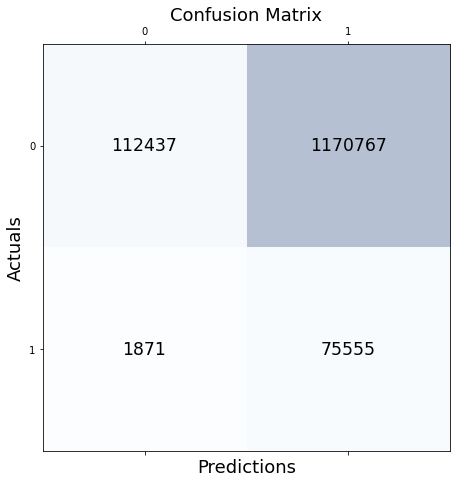

In [119]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=predictions_oos['actual'], y_pred=predictions_oos['predicted_class'])
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [120]:
from sklearn.metrics import classification_report

In [121]:
print(classification_report(predictions_oos['actual'],predictions_oos['predicted_class']))

              precision    recall  f1-score   support

           0       0.98      0.09      0.16   1283204
           1       0.06      0.98      0.11     77426

    accuracy                           0.14   1360630
   macro avg       0.52      0.53      0.14   1360630
weighted avg       0.93      0.14      0.16   1360630

